# EEG Data
The data sets we will be working with are open source data collected at the École Polytechnique Fédéral de Lausanne for a BCI (Brain Computer Interface) project; the full data set and can downloaded [here](http://mmspg.epfl.ch/BCI_datasets). We have done some re-organization of the data to make it easier to load; if you would like to try to work with the whole data set, see the notebook [here](blah) for how we re-organized things.



# Imports etc (pre-Chris-stuff)

In [1]:
import os
import glob
import numpy as np
import scipy.io as si
import matplotlib.pyplot as plt
from scipy.stats import zscore
import datetime

import neurods
import mne

In [ ]:
# TEMP
neurods.io.data_list['eeg'] = '/Users/mark/gdrive/neuro_connector/data/eeg/'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.aspect'] = 'auto'

# Load eeg data
(plot it)

(look how different from fMRI!)

Need a reference electorde

Care less about high-frequency jitter (what's high frequency?): filter high freqs out!

# Experiment design

In [72]:
import pandas

In [73]:
hrm = pandas.DataFrame.from_csv('/Users/mark/Dropbox/data8/eeg/subject8/session1/events-eve.txt')

In [74]:
hrm

Empty DataFrame
Columns: []
Index: [  1638      0   4,   2460      0   5,   3279      0   2,   4100      0   3,   4919      0   6,   5741      0   3,   6562      0   6,   7381      0   5,   8202      0   2,   9021      0   1,   9843      0   4,  10662      0   1,  11483      0   2,  12304      0   4,  13124      0   5,  13945      0   6,  14764      0   3,  15585      0   4,  16407      0   3,  17226      0   1,  18047      0   5,  18866      0   6,  19687      0   2,  20507      0   3,  21328      0   6,  22149      0   1,  22968      0   4,  23790      0   2,  24609      0   5,  25430      0   1,  26249      0   4,  27070      0   6,  27892      0   3,  28711      0   5,  29532      0   2,  30351      0   6,  31173      0   3,  31992      0   5,  32813      0   1,  33634      0   2,  34454      0   4,  35275      0   4,  36094      0   5,  36915      0   6,  37736      0   3,  38556      0   1,  39397      0   2,  40196      0   2,  41017      0   5,  41837      0   1,  42658      0   3,  43479      0   4,  44298      0   6,  45119      0   4,  45939      0   6,  46760      0   3,  47579      0   1,  48400      0   2,  49222      0   5,  50041      0   3,  50862      0   2,  51681      0   4,  52503      0   1,  53322      0   6,  54143      0   5,  54964      0   1,  55783      0   6,  56605      0   5,  57424      0   2,  58245      0   3,  59064      0   4,  59886      0   2,  60707      0   6,  61526      0   4,  62347      0   3,  63166      0   5,  63988      0   1,  64809      0   1,  65628      0   6,  66449      0   2,  67269      0   4,  68090      0   5,  68909      0   3,  69730      0   6,  70552      0   5,  71371      0   2,  72192      0   1,  73011      0   4,  73832      0   3,  74652      0   3,  75473      0   5,  76294      0   6,  77113      0   4,  77935      0   2,  78754      0   1,  79575      0   6,  80394      0   1,  81215      0   5,  82037      0   3,  82938      0   4, ...]

[137 rows x 0 columns]

# Select a single trial

In [ ]:
first_onset = 0.400 # 400 ms
offset_idx_ = int(np.ceil(sfreq*first_onset)) # Index to be added to all events 
                                              # (because first event time was NOT actually zero)

assert offset_idx==offset_idx, 'Offset indices are not equal!'

def extract_epochs(data, onset_times, tmin=-0.1, tmax=0.6, sfreq=2048, 
                   offset_idx=offset_idx, is_verbose=False):
    """Extract peri-stimulus epochs"""
    epochs = []    
    for time in onset_times:
        # Find event onset / offset index
        #time_scaled = time - t0 # first time is already zero
        
        onset_index = int(sfreq * time) + offset_idx
        if is_verbose:
            print('Onset index = %d'%onset_index)
        event_start_idx = onset_index + int(sfreq * tmin)
        event_end_idx = onset_index + int(sfreq * tmax)
        if is_verbose:
            print("Extracting indices from %d to %d"%(event_start_idx, event_end_idx))
        # Calculate window
        data_slice = data[:, event_start_idx:event_end_idx]
        data_slice = zscore(data_slice, axis=1)
        if is_verbose:
            print("Data slice is of shape {}".format(data_slice.shape))
        epochs.append(data_slice)
    # Concatenate together all epochs we have extracted
    epochs = np.array(epochs)
    times = np.linspace(tmin, tmax, num=epochs.shape[-1])

    # Baseline by pre-stimulus times
    baseline_type = 'zscore'  # 'zscore' , 'mean'
    epochs = mne.baseline.rescale(epochs, times, (None, 0), baseline_type, verbose=is_verbose)
    return epochs, times

In [4]:
# Experiment parameters
sfreq = 2048
offset_idx = 820 # = 400 ms * sfreq
electrode_names = ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 
                   'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 
                   'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 
                   'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 
                   'Cz', 'MA1', 'MA2']
reference_electrodes = [6,23] # This experiment uses reference electrodes on the temporal lobes

['T7', 'T8']


In [16]:
# Load data for testing / play
subject, session, run = 8, 1, 0
fdir = os.path.join(neurods.io.data_list['eeg'], 'epfl_p300_speller/orig/subject{}/session{}/'.format(subject, session))
files = sorted(glob.glob(os.path.join(fdir, '*mat')))
all_data = si.loadmat(files[run])

In [18]:
# Deal with idiotic events array
def convert_time(tarray):
    te = tarray[:,-1:]
    tarray = np.hstack([tarray[:,:-1], np.floor(te), (te%1)*1000000])
    tarray = tarray.astype(np.int32)
    dt = [datetime.datetime(*t) for t in tarray]
    time = np.array([(x-dt[0]).total_seconds() for x in dt])
    return time

# EEG data requires a reference

In [47]:
def load_p300_data(subject, session, run, ref_electrode_idx=(6,23), is_verbose=False,
                  do_filter=True, do_reference=True, filter_cutoffs=(1,12)):
    """Load EEG data"""
    fdir = os.path.join(neurods.io.data_list['eeg'], 'epfl_p300_speller', 'orig', 'subject{}/session{}/'.format(subject, session))
    files = sorted(glob.glob(os.path.join(fdir, '*mat')))
    all_data = si.loadmat(files[run])
    # EEG data
    data = all_data['data']
    # Mastoid reference
    mastoids = data[-2:] # data[[-2, -1]] # what is this odd indexing? Does this copy the array or something?
    # Remove mastoids
    data = data[:-2]
    ref_electrodes = data[list(ref_electrode_idx)]
    if is_verbose:
        print("Reference electrode shape:",ref_electrodes.shape)
    #data -= mastoids.mean(0)
    if do_reference:
        data -= ref_electrodes.mean(0)
    # Smooth the data
    if do_filter:
        fmin, fmax = filter_cutoffs # Set cutoffs for low and high frequency in data
        data = mne.filter.filter_data(data, sfreq, fmin, fmax, verbose=False)
    # Image they were supposed to focus on
    target = all_data['target'].squeeze()
    # The number of times the subject reported the target flashed
    target_counts = all_data['targets_counted'].squeeze()
    # Image that was flashed for each event
    stimuli = all_data['stimuli'].squeeze()
    design = np.array([stimuli==x for x in np.unique(all_data['stimuli'])])
    # Time of each event in seconds
    event_times = convert_time(all_data['events'])
    
    return data, design, event_times, target_counts, target

In [22]:
first_onset = 0.400 # 400 ms
offset_idx_ = int(np.ceil(sfreq*first_onset)) # Index to be added to all events 
                                              # (because first event time was NOT actually zero)

assert offset_idx==offset_idx, 'Offset indices are not equal!'

def extract_epochs(data, onset_times, tmin=-0.1, tmax=0.6, sfreq=2048, 
                   offset_idx=offset_idx, is_verbose=False):
    """Extract peri-stimulus epochs"""
    epochs = []    
    for time in onset_times:
        # Find event onset / offset index
        #time_scaled = time - t0 # first time is already zero
        
        onset_index = int(sfreq * time) + offset_idx
        if is_verbose:
            print('Onset index = %d'%onset_index)
        event_start_idx = onset_index + int(sfreq * tmin)
        event_end_idx = onset_index + int(sfreq * tmax)
        if is_verbose:
            print("Extracting indices from %d to %d"%(event_start_idx, event_end_idx))
        # Calculate window
        data_slice = data[:, event_start_idx:event_end_idx]
        data_slice = zscore(data_slice, axis=1)
        if is_verbose:
            print("Data slice is of shape {}".format(data_slice.shape))
        epochs.append(data_slice)
    # Concatenate together all epochs we have extracted
    epochs = np.array(epochs)
    times = np.linspace(tmin, tmax, num=epochs.shape[-1])

    # Baseline by pre-stimulus times
    baseline_type = 'zscore'  # 'zscore' , 'mean'
    epochs = mne.baseline.rescale(epochs, times, (None, 0), baseline_type, verbose=is_verbose)
    return epochs, times

In [25]:
subject = 8 # 1-2 (9 total, not downloaded...)
session = 2 # 1-4
run = 1
data, design, event_times, target_counts, target = load_p300_data(subject, session, run)
epochs = {}
for icond, cond in enumerate(design):
    epochs[icond+1], times = extract_epochs(data, event_times[cond][:3])

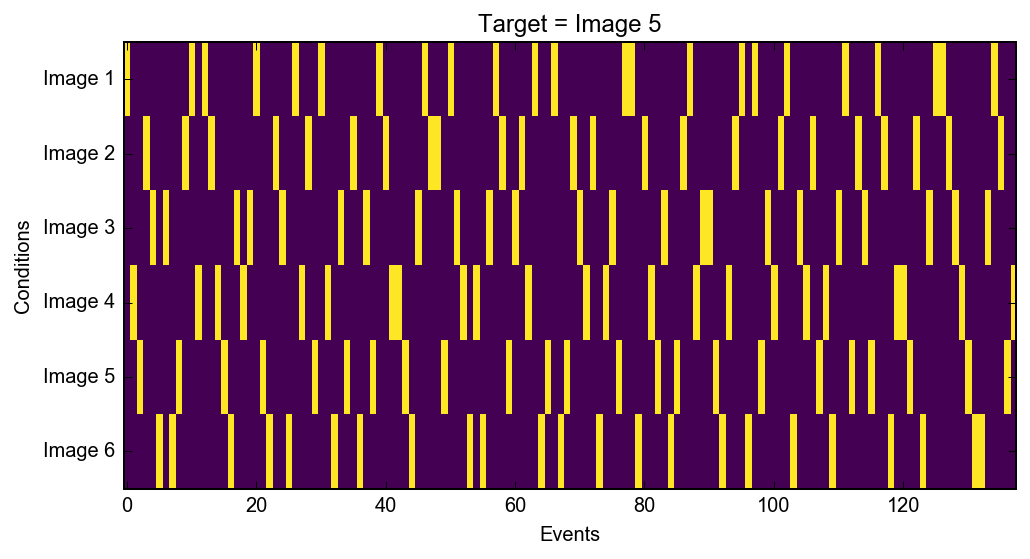

In [52]:
if False:
    plt.figure(figsize=(8,4))
    plt.imshow(design)
    plt.xlabel('Events')
    plt.ylabel('Conditions')
    plt.yticks(range(6), ['Image {}'.format(i) for i in range(1,6+1)])
    _ = plt.title('Target = Image {}'.format(target))

In [27]:
print(epochs.keys())
print(epochs[1].shape)

dict_keys([1, 2, 3, 4, 5, 6])
(3, 32, 1432)


In [28]:
# how many trials per condition (per target)
design.sum(1)

array([24, 24, 24, 24, 24, 24])

In [35]:
# Plot mean response to selected stimulus in each electrode
def plot_target_responses(all_epochs, all_images, true_target, ylim=(-5,5), sqmean=True):
    n_images = len(all_images)
    fig, axs = plt.subplots(3, 2, figsize=(10,6), sharey=True,
                            sharex=True)

    # Iterate through each target type
    for ax, (target, epochs) in zip(axs.flatten(), all_epochs.items()):
        # Plot mean of each channel
        average = epochs.mean(0)
        ax.plot(times, average.T, alpha=.5)

        # Global Field Potential
        if sqmean:
            grand = (average ** 2).mean(0)
        else:
            grand = average.mean(0)
        ax.plot(times, grand, color='k', lw=4)
        ax.axvline(0, color='r', ls='--')
        ax.set(title='Flashed: {}'.format(target))
        ax.grid(axis='x')
        if target == true_target:
            plt.setp(ax.title, color='r')
    if ylim is not None:
        _ = plt.ylim(ylim)
    plt.suptitle('Subject {}, session {}, run {}, target={}'.format(subject, session, run+1, true_target))

# Whole sessions per subject

A problem with several of the subjects was outlying responses at the end of the timecoures. You can see it in this plot. I'm not sure whether we should try to have students find this out themselves or just give it to them (it could be a good exercise in outlier detection).

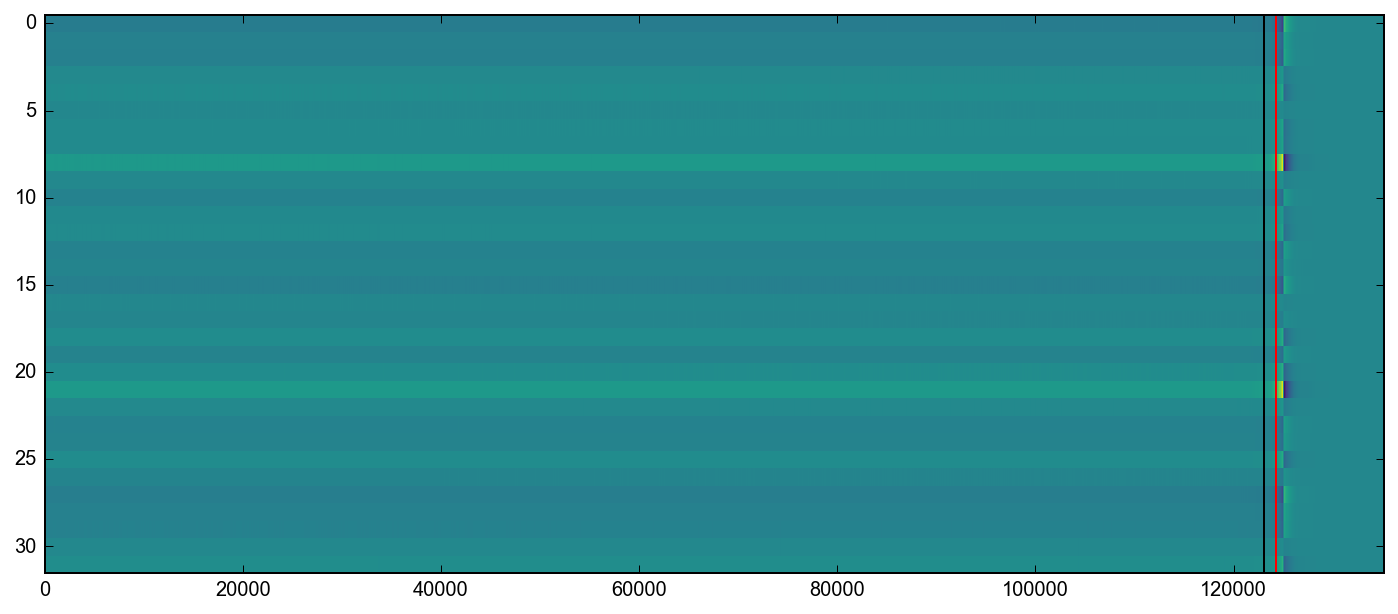

In [27]:
plt.figure(figsize=(12,5))
plt.imshow(data)
# Last trial start (black) and end (red)
plt.vlines(event_times[-1] * sfreq + offset_idx, -0.5, 31.5, color='k')
plt.vlines(event_times[-1] * sfreq + offset_idx + 0.6*sfreq, -0.5, 31.5, color='r')

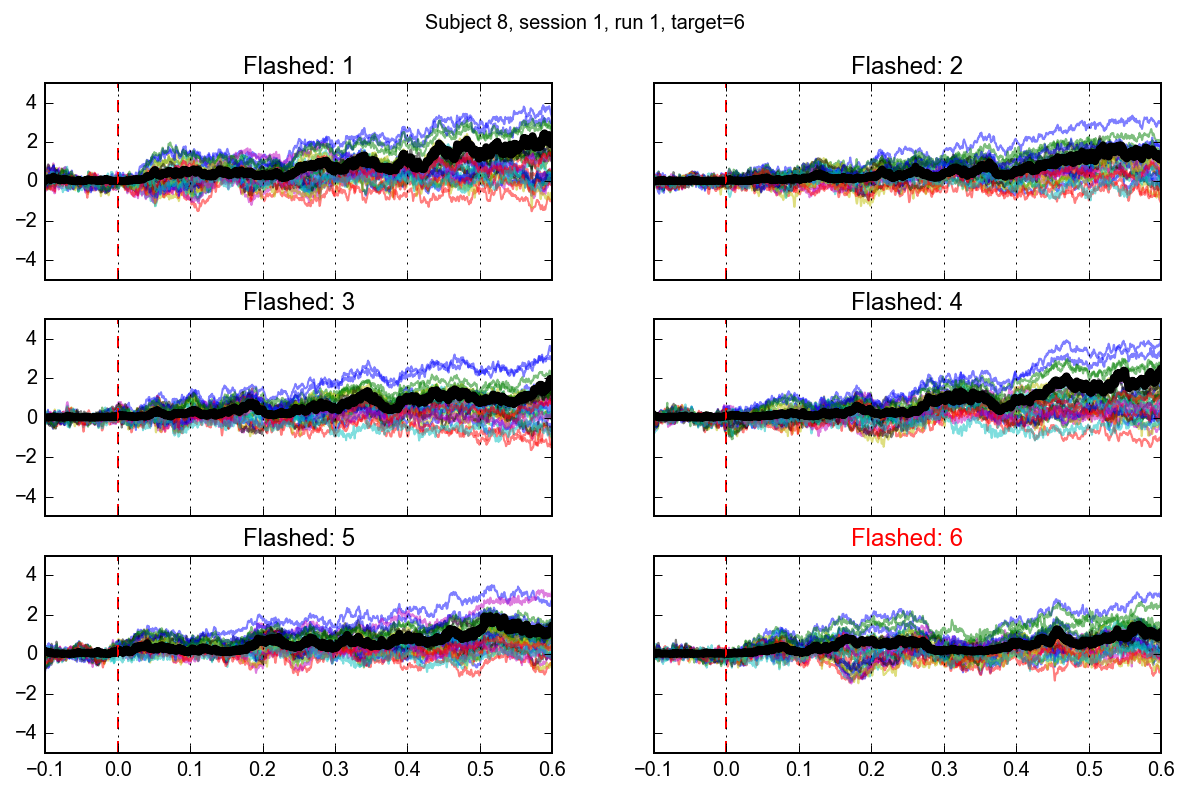

In [48]:
# NO FILTERING, NO REFERENCE
subject = 8 # 1-2 or 8 (9 total, not all downloaded...)
session = 1 # 1-4
for run in range(1): # 1-6
    data, design, event_times, target_counts, target = load_p300_data(subject, session, run, do_reference=False, do_filter=False)    
    epochs = {}
    for icond, cond in enumerate(design):
        epochs[icond+1], times = extract_epochs(data, event_times[cond][:-1])

    plot_target_responses(epochs, range(6), target, ylim=(-5,5))

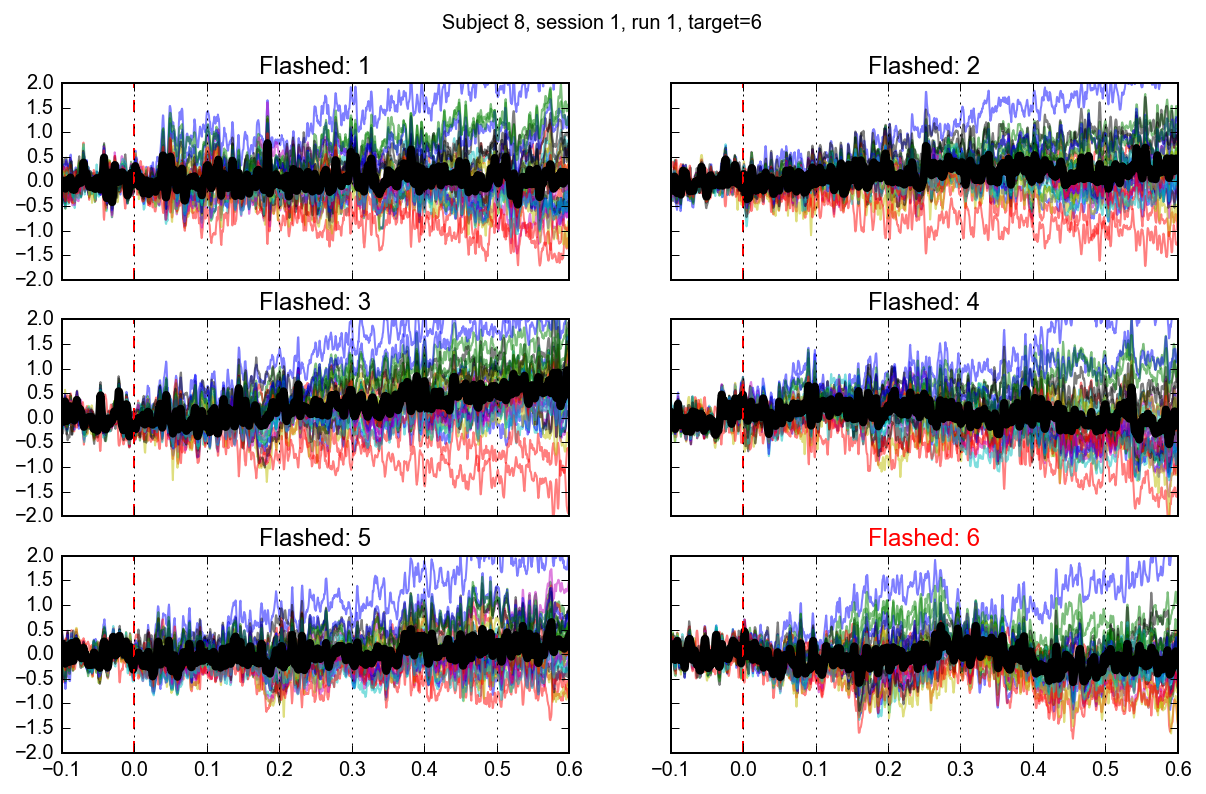

In [52]:
# NO FILTERING, WITH REFERENCE
subject = 8 # 1-2 or 8 (9 total, not all downloaded...)
session = 1 # 1-4
for run in range(1): # 1-6
    data, design, event_times, target_counts, target = load_p300_data(subject, session, run, do_reference=True, do_filter=False)    
    epochs = {}
    for icond, cond in enumerate(design):
        epochs[icond+1], times = extract_epochs(data, event_times[cond][:-1])

    plot_target_responses(epochs, range(6), target, ylim=(-2,2), sqmean=False)

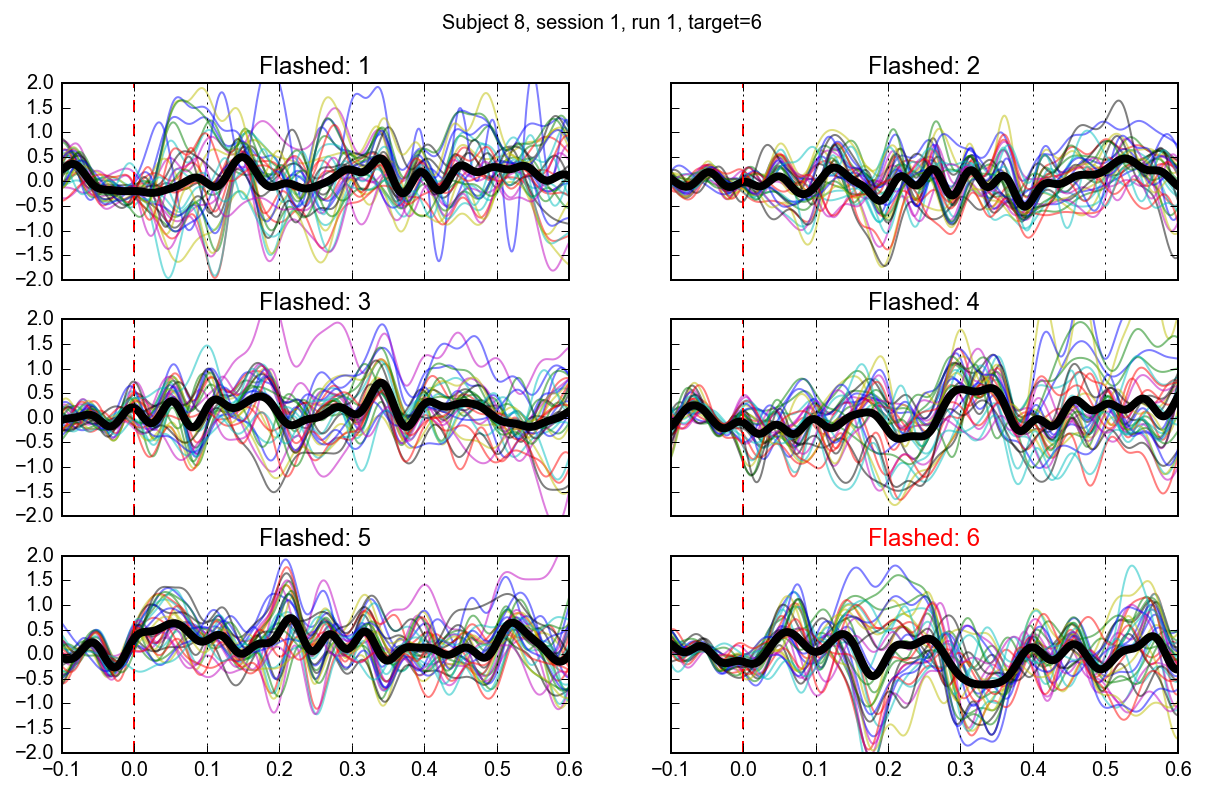

In [54]:
# WITH FILTERING, NO REFERENCE
subject = 8 # 1-2 or 8 (9 total, not all downloaded...)
session = 1 # 1-4
for run in range(1): # 1-6
    data, design, event_times, target_counts, target = load_p300_data(subject, session, run, do_reference=False, 
                                                                      do_filter=True)
    epochs = {}
    for icond, cond in enumerate(design):
        epochs[icond+1], times = extract_epochs(data, event_times[cond][:-1])

    plot_target_responses(epochs, range(6), target, ylim=(-2,2), sqmean=False)

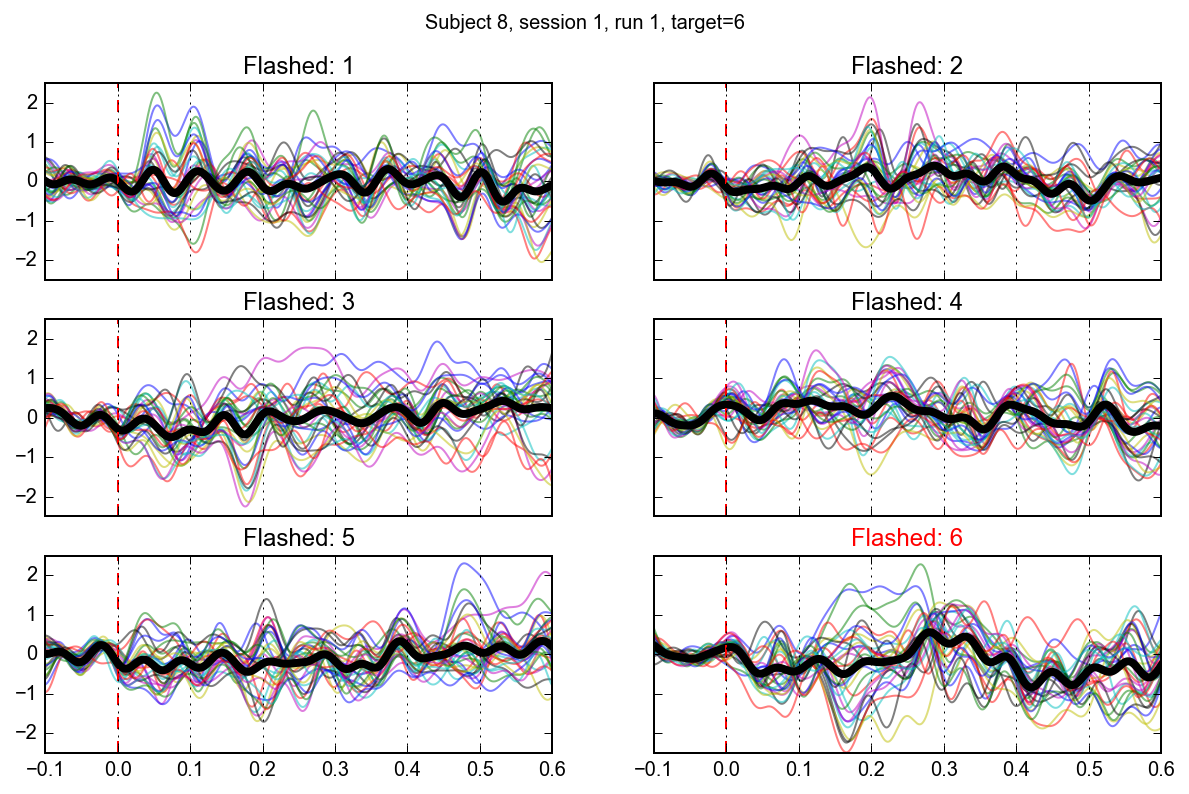

In [55]:
# WITH FILTERING, WITH REFERENCE
subject = 8 # 1-2 or 8 (9 total, not all downloaded...)
session = 1 # 1-4
for run in range(1): # 1-6
    data, design, event_times, target_counts, target = load_p300_data(subject, session, run, do_reference=True, do_filter=True)    
    epochs = {}
    for icond, cond in enumerate(design):
        epochs[icond+1], times = extract_epochs(data, event_times[cond][:-1])

    plot_target_responses(epochs, range(6), target, ylim=(-2.5,2.5), sqmean=False)

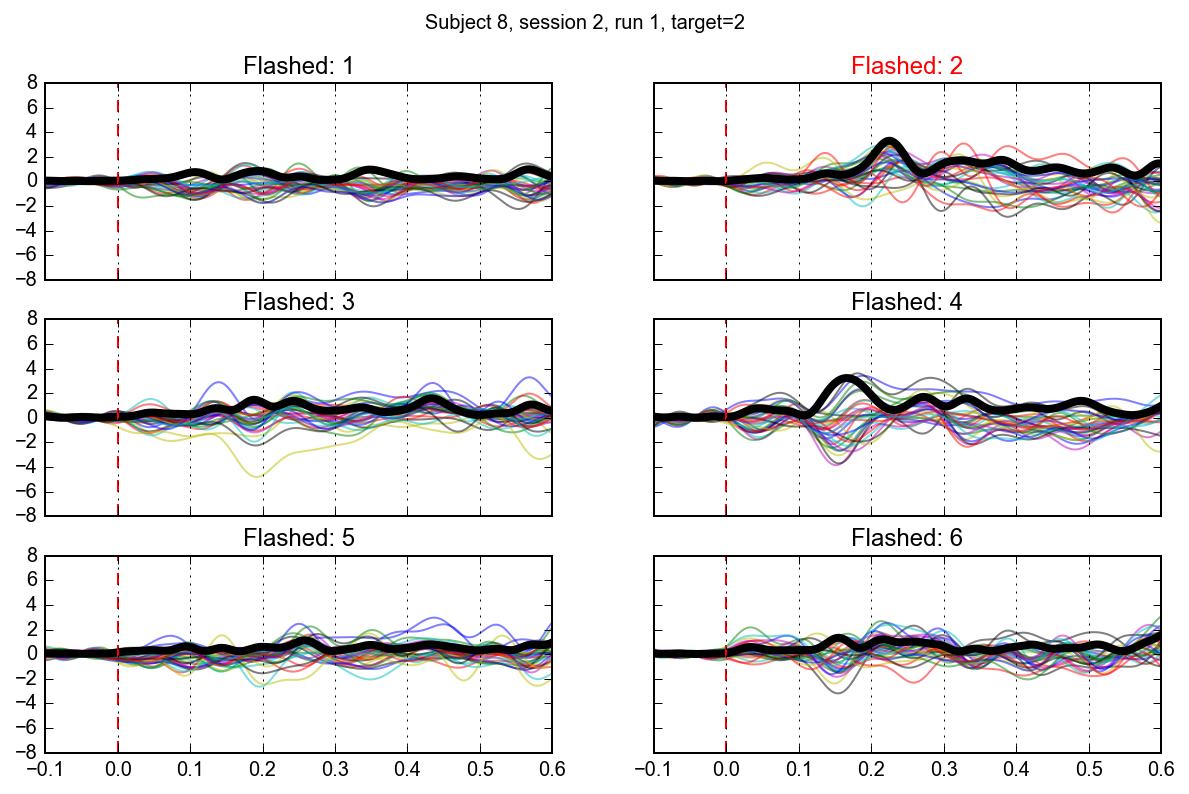

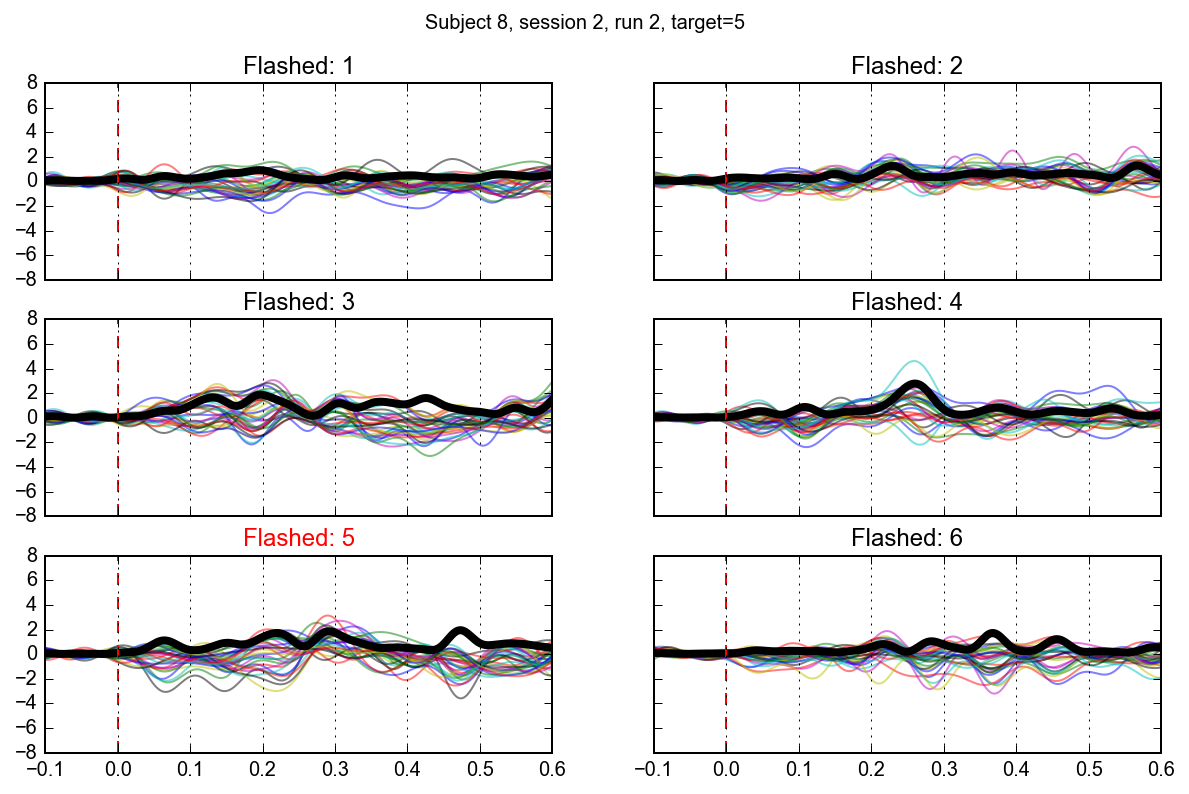

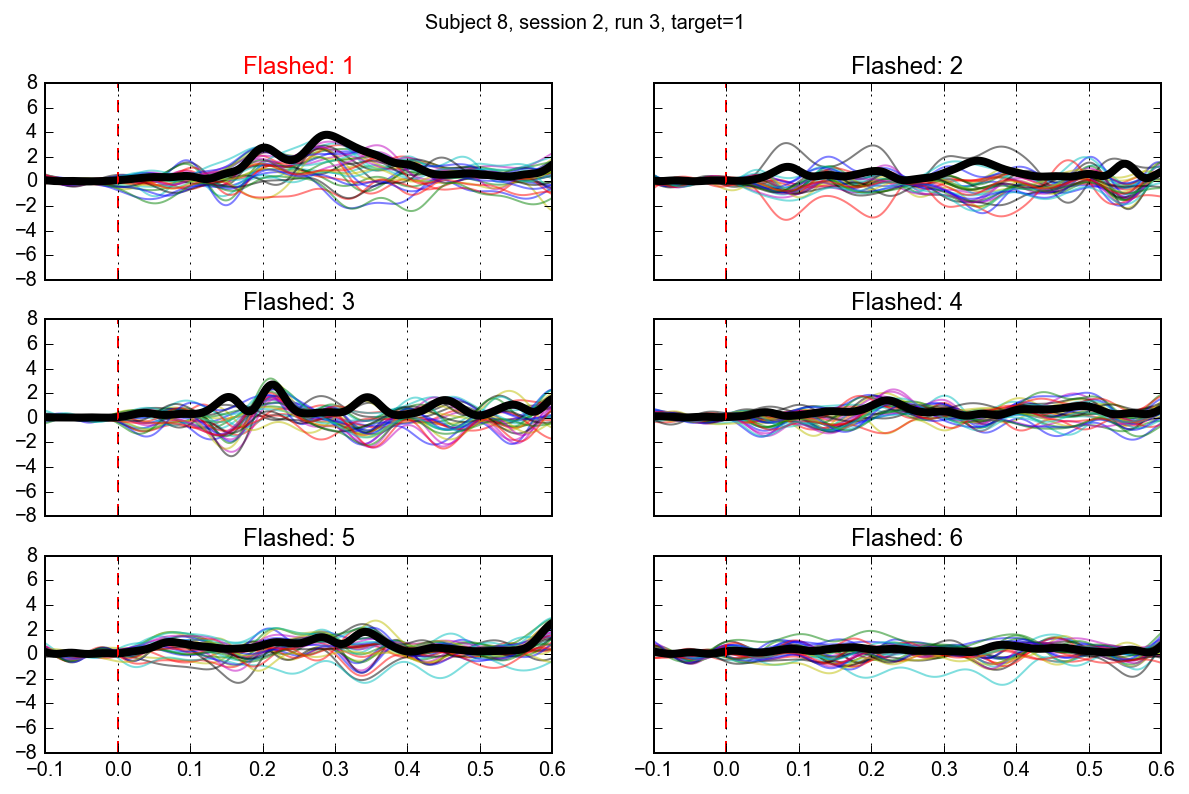

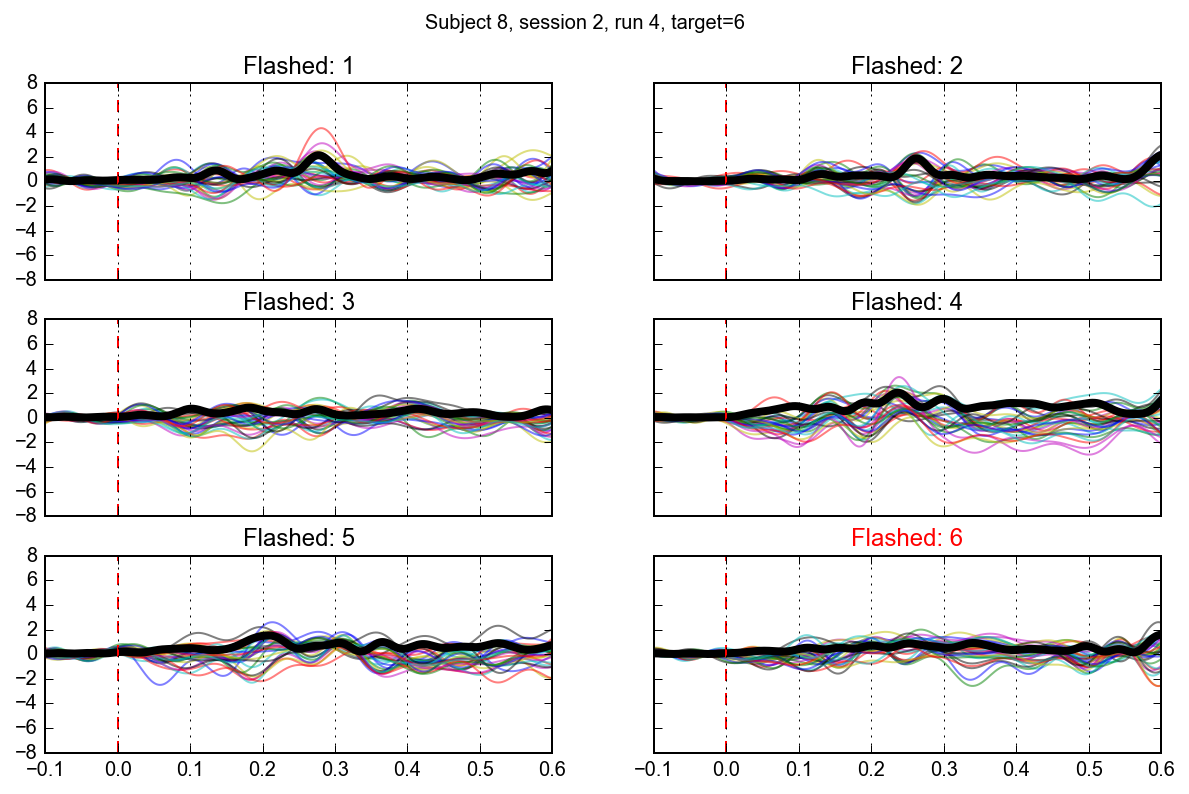

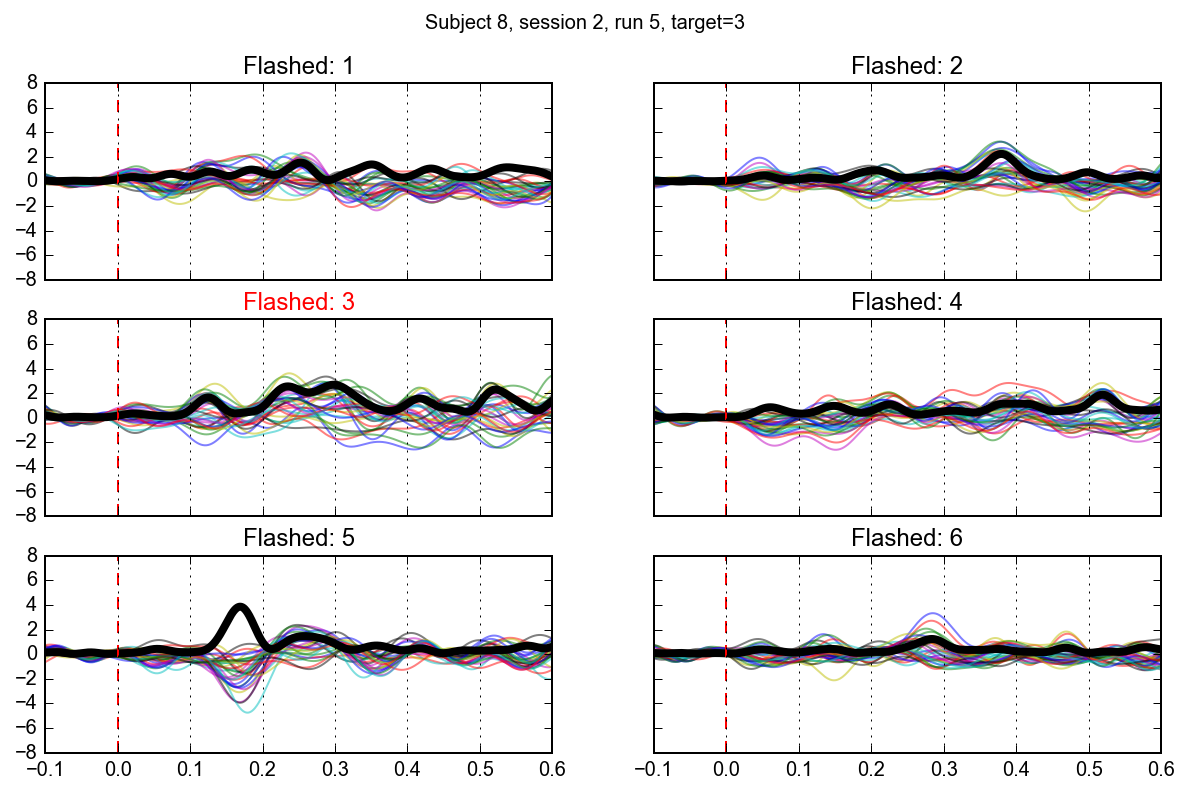

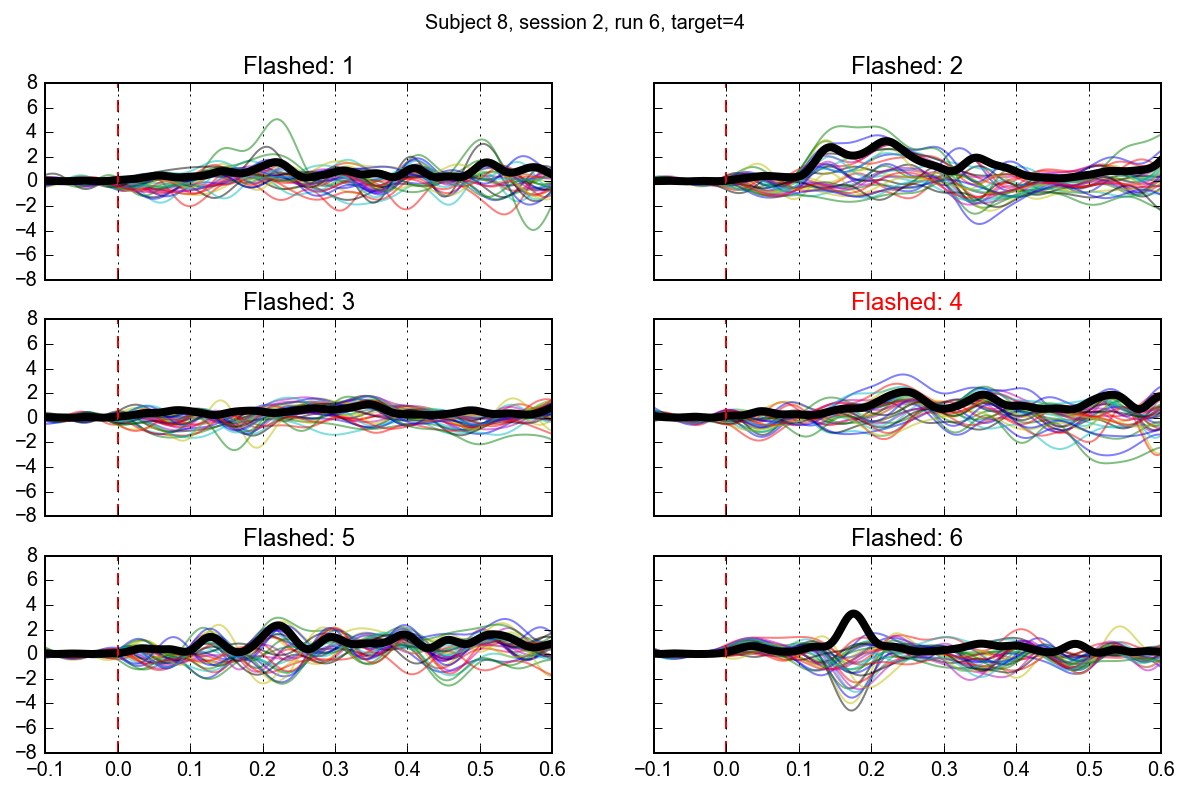

In [68]:
subject = 8 # 1-2 or 8 (9 total, not all downloaded...)
session = 2 # 1-4
for run in range(6): # 1-6
    data, design, event_times, target_counts, target = load_p300_data(subject, session, run)    
    epochs = {}
    for icond, cond in enumerate(design):
        epochs[icond+1], times = extract_epochs(data, event_times[cond][:-1])

    plot_target_responses(epochs, range(6), target, ylim=(-8,8))

# Target vs not-target responses

In [56]:
subject = 8 # 1-2 or 8 (9 total, not all downloaded...)
session = 1 # 1-4
image_as_target = []
image_not_target = []
for run in range(6): # 1-6
    data, design, event_times, target_counts, target = load_p300_data(subject, session, run)
    for icond, cond in enumerate(design, 1):
        epochs_tmp, times = extract_epochs(data, event_times[cond][:-1])
        if icond == target:
            image_as_target.append(epochs_tmp)
        else:
            image_not_target.append(epochs_tmp)
t = np.vstack(image_as_target)
n = np.vstack(image_not_target)

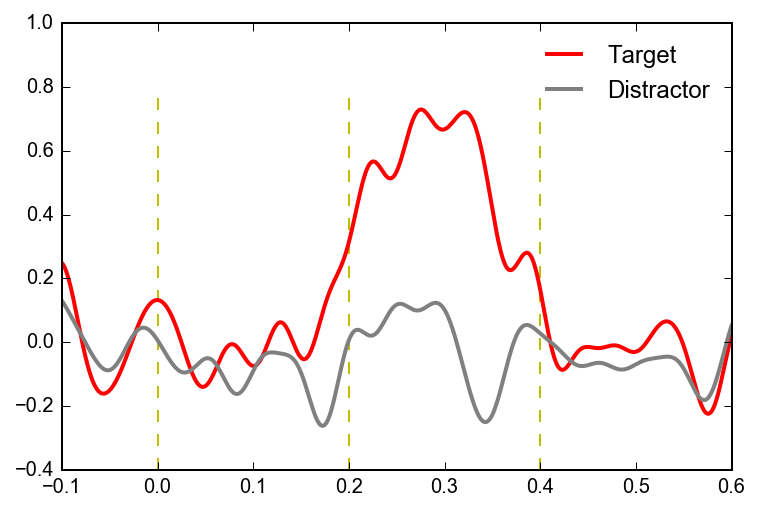

In [57]:
fig, axs = plt.subplots()
axs.plot(times, t.mean(0).mean(0), lw=2, color='red', label='Target')
axs.plot(times, n.mean(0).mean(0), lw=2, color='gray', label='Distractor')
axs.vlines([0, 0.2, 0.4], *axs.get_ylim(), colors='y', linestyle='--')
axs.legend(frameon=False)

In [41]:
subject = 8 # 1-2 or 8 (9 total, not all downloaded...)
session = 1 # 1-4
image_as_target = {}
image_not_target = {}
for run in range(6): # 1-6
    data, design, event_times, target_counts, target = load_p300_data(subject, session, run)    
    for icond, cond in enumerate(design, 1):
        epochs_tmp, times = extract_epochs(data, event_times[cond][:-1])
        if icond == target:
            image_as_target[icond] = epochs_tmp
        else:
            if icond not in image_not_target:
                image_not_target[icond] = epochs_tmp
            else:
                image_not_target[icond] = np.vstack([image_not_target[icond], epochs_tmp])

In [27]:
target

array(6, dtype=uint8)

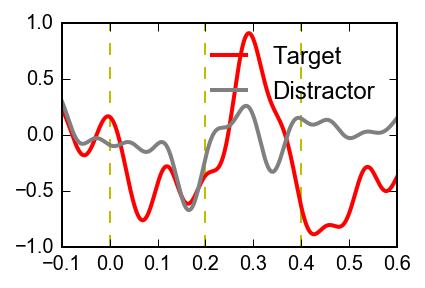

In [42]:
fig, axs = plt.subplots(figsize=(3,2), sharey=False, sharex=True)
axs.plot(times, (image_as_target[6].mean(0)).mean(0), lw=2, color='red', label='Target')
axs.plot(times, (image_not_target[6].mean(0)).mean(0), lw=2, color='gray', label='Distractor')
axs.vlines([0, 0.2, 0.4], *axs.get_ylim(), colors='y', linestyle='--')
axs.legend(frameon=False)

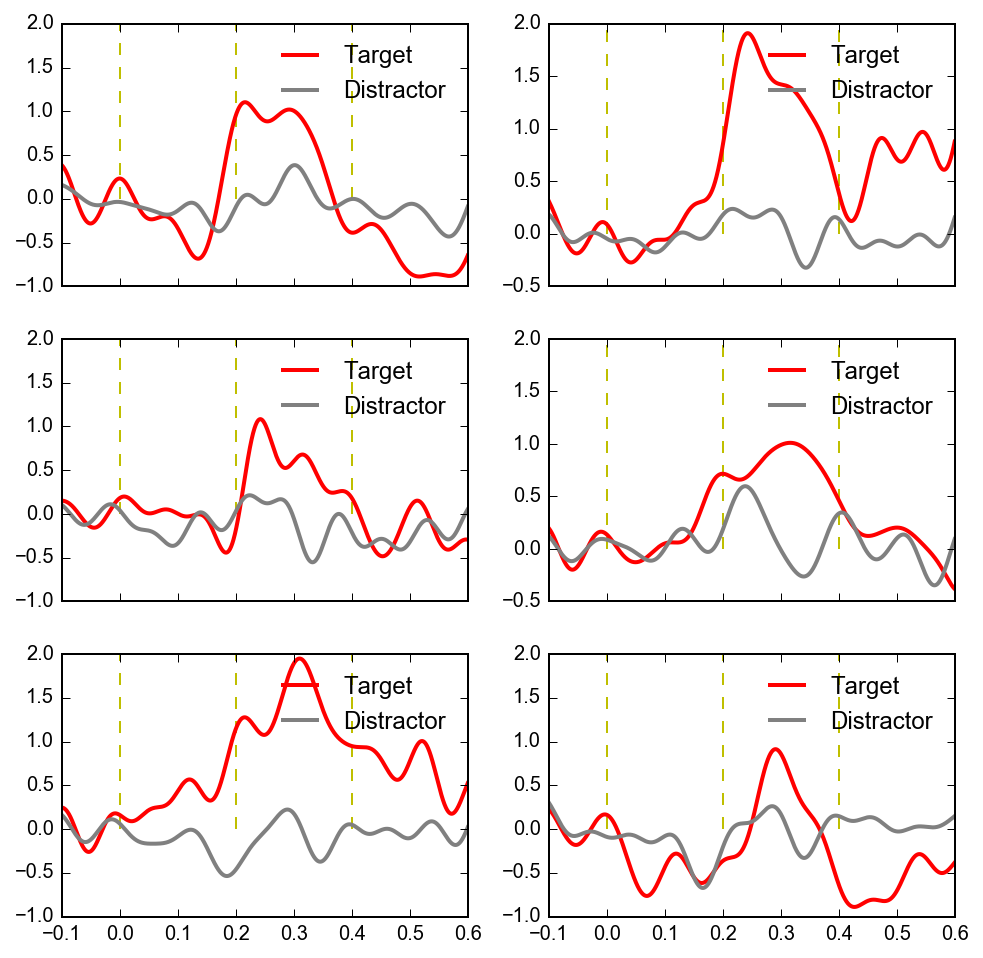

In [45]:
fig, axs = plt.subplots(3, 2, figsize=(8,8), sharey=False, sharex=True)
for ii, ax in enumerate(axs.flatten(), 1):
    ax.plot(times, (image_as_target[ii].mean(0)).mean(0), lw=2, color='red', label='Target')
    ax.plot(times, (image_not_target[ii].mean(0)).mean(0), lw=2, color='gray', label='Distractor')
    ax.vlines([0, 0.2, 0.4], 0, 2, colors='y', linestyle='--')
    ax.legend(frameon=False)

# Original code from Chris

In [41]:
all_targets = np.unique(stimuli) # range(1,7)
all_epochs = {}
for target_plt in all_targets:
    epochs = []
    for time, stimulus  in zip(event_times, stimuli):
        if stimulus != target_plt:
            continue

        # Find event onset index
        diff = time - event_times[0]
        ix_event = int(sfreq * diff) + offset_ixs

        # Calculate window
        tmin, tmax = -.1, .6
        ix_start, ix_stop = [ix_event + int(np.floor(ii * sfreq)) for ii in [tmin, tmax]]
        data_slice = data[:, ix_start:ix_stop]
        data_slice = scale(data_slice.T).T
        epochs.append(data_slice)
    epochs = np.array(epochs)
    times = np.linspace(tmin, tmax, num=epochs.shape[-1])
    
    # Baseline by pre-stimulus times
    baseline_type = 'zscore'  # 'zscore' , 'mean'
    epochs = mne.baseline.rescale(epochs, times, (None, 0), baseline_type)
    all_epochs[target_plt] = epochs

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


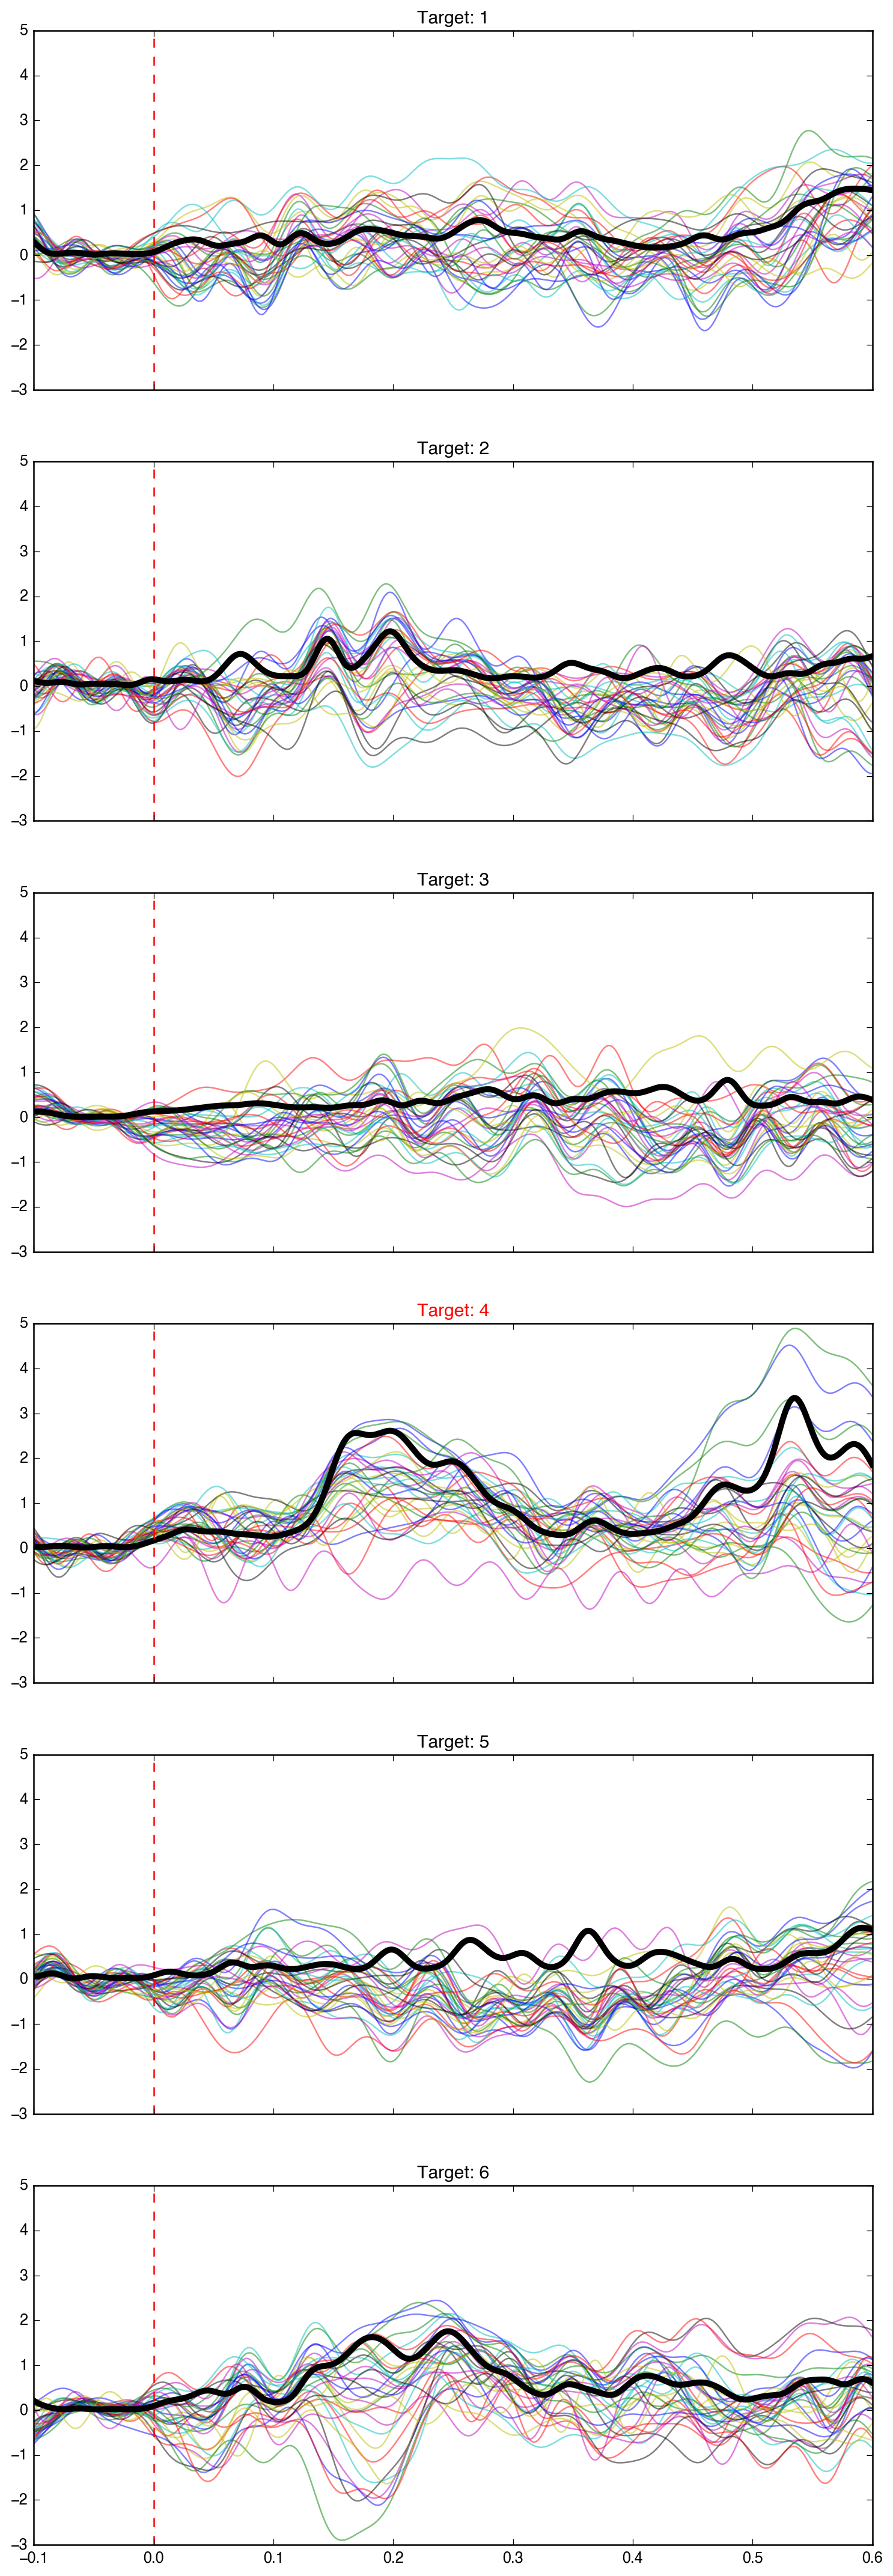

In [15]:
# Plot mean response to selected stimulus in each electrode
n_targets = len(all_targets)
fig, axs = plt.subplots(n_targets, 1, figsize=(10, 5 * n_targets), sharey=True,
                        sharex=True)

# Iterate through each target type
for ax, (target, epochs) in zip(axs, all_epochs.items()):
    # Plot mean of each channel
    average = epochs.mean(0)
    ax.plot(times, average.T, alpha=.5)
    
    # Global Field Potential
    grand = (average ** 2).mean(0)
    ax.plot(times, grand, color='k', lw=4)
    ax.axvline(0, color='r', ls='--')
    ax.set(title='Target: {}'.format(target))
    if target == true_target:
        plt.setp(ax.title, color='r')

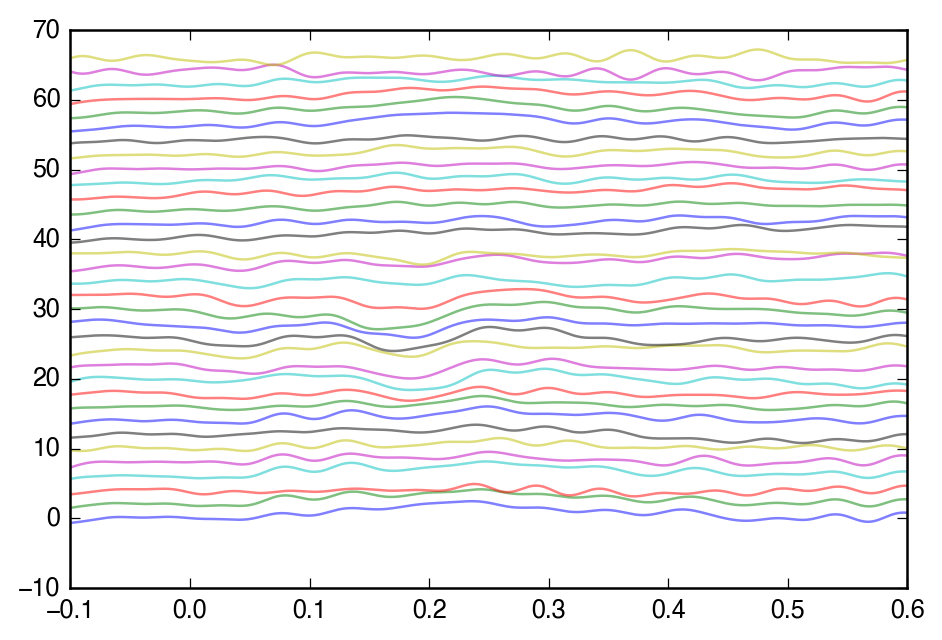

In [16]:
# Show all channels w/ offset
# Maybe good to show before the plots above
for ii, av in enumerate(average):
    _ = plt.plot(times, av + ii * 2, alpha=.5)